In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [2]:
file_path = './ratings_small.csv'
ratings_data = pd.read_csv(file_path)
print(ratings_data.head())

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205


In [3]:
# Filter the DataFrame to include only ratings of 4 and above
filtered_ratings = ratings_data[ratings_data['rating'] >= 4]

# Display the filtered DataFrame
print(filtered_ratings.head())

    userId  movieId  rating   timestamp
4        1     1172     4.0  1260759205
12       1     1953     4.0  1260759191
13       1     2105     4.0  1260759139
20       2       10     4.0   835355493
21       2       17     5.0   835355681


In [4]:
user_item_matrix = filtered_ratings.pivot(index='userId', columns='movieId', values='rating')

# Step 2: Fill NaN values with 0 (unrated movies become 0)
user_item_matrix = user_item_matrix.fillna(0)

# Step 3: Convert the DataFrame to a sparse matrix
sparse_matrix = csr_matrix(user_item_matrix.values)

# Output the sparse matrix details
print(f"Sparse Matrix Shape: {sparse_matrix.shape}")  # Shape of the matrix
print(f"Number of Non-Zero Elements: {sparse_matrix.nnz}")  # Non-zero elements count
print(sparse_matrix)

# Optional: Preview the dens

Sparse Matrix Shape: (671, 6170)
Number of Non-Zero Elements: 51568
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 51568 stored elements and shape (671, 6170)>
  Coords	Values
  (0, 805)	4.0
  (0, 1296)	4.0
  (0, 1416)	4.0
  (1, 8)	4.0
  (1, 15)	5.0
  (1, 34)	5.0
  (1, 41)	4.0
  (1, 44)	4.0
  (1, 91)	4.0
  (1, 114)	5.0
  (1, 117)	4.0
  (1, 176)	5.0
  (1, 202)	4.0
  (1, 210)	4.0
  (1, 213)	5.0
  (1, 214)	5.0
  (1, 221)	4.0
  (1, 239)	4.0
  (1, 253)	4.0
  (1, 283)	4.0
  (1, 284)	4.0
  (1, 363)	4.0
  (1, 375)	4.0
  (1, 384)	4.0
  (1, 399)	4.0
  :	:
  (670, 2318)	4.0
  (670, 2545)	4.0
  (670, 2702)	4.0
  (670, 2715)	4.0
  (670, 2718)	4.0
  (670, 2719)	4.5
  (670, 2846)	5.0
  (670, 3103)	4.0
  (670, 3105)	5.0
  (670, 3110)	5.0
  (670, 3134)	4.5
  (670, 3142)	4.5
  (670, 3152)	5.0
  (670, 3154)	4.0
  (670, 3295)	4.0
  (670, 3303)	4.0
  (670, 3328)	4.5
  (670, 3401)	4.0
  (670, 3435)	4.0
  (670, 3478)	5.0
  (670, 3490)	4.0
  (670, 3491)	4.5
  (670, 3493)	4.0
  (670, 3566)	4.0
 

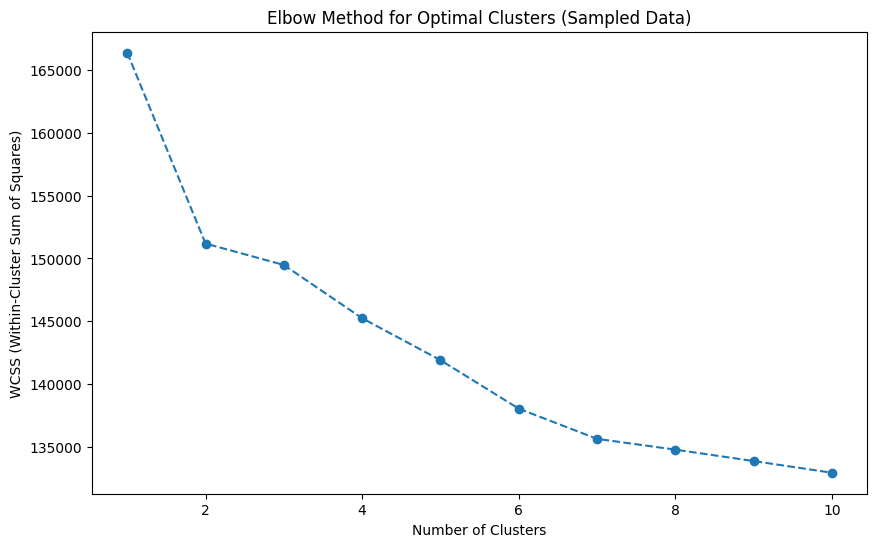

In [5]:
sampled_matrix = user_item_matrix.sample(frac=0.1, random_state=42)  # Use 10% of the data
sampled_matrix = user_item_matrix.iloc[:, :500]  # Use only the first 500 movies
wcss = []
for i in range(1, 11):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(sampled_matrix.values)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters (Sampled Data)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

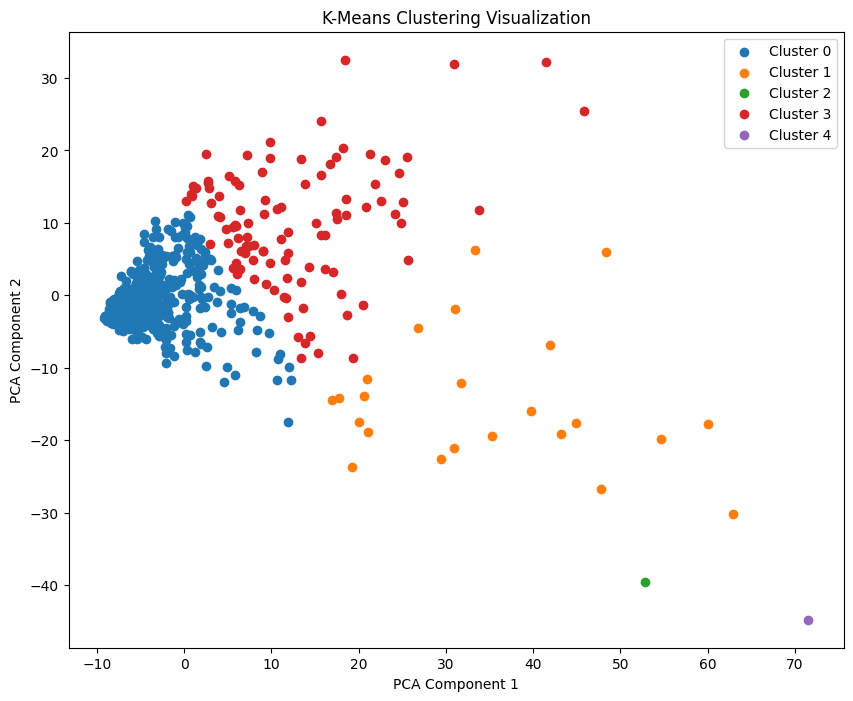

In [6]:
# Step 1: Define the number of clusters
num_clusters = 5  # You can adjust this after performing the elbow method

# Step 2: Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
user_item_matrix['Cluster'] = kmeans.fit_predict(user_item_matrix.values)

# Step 3: Visualize clusters using PCA (reduce to 2D for visualization)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(user_item_matrix.values)

# Step 4: Plot the clusters
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_data = pca_components[user_item_matrix['Cluster'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

# Add plot labels and title
plt.title('K-Means Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [7]:
# Calculate the average rating and the total number of ratings per movie
user_item_matrix['avg_rating'] = user_item_matrix.mean(axis=1)
user_item_matrix['num_ratings'] = (user_item_matrix > 0).sum(axis=1)


In [8]:
# Group data by clusters to compute summary statistics
cluster_summary = user_item_matrix.groupby('Cluster').agg(
    avg_rating=('avg_rating', 'mean'),       # Mean of average ratings in the cluster
    total_ratings=('num_ratings', 'sum'),   # Total number of ratings in the cluster
    count=('Cluster', 'size')               # Number of items in the cluster
)

# Print the cluster summary
print(cluster_summary)


         avg_rating  total_ratings  count
Cluster                                  
0          0.030070          23531    544
1          0.271420           8920     23
2          0.380489            545      1
3          0.125309          18253    102
4          0.789499           1117      1


In [9]:
# Check if 'Cluster' column exists in user_item_matrix
print(user_item_matrix.columns)


Index([            1,             2,             3,             5,
                   6,             7,             8,             9,
                  10,            11,
       ...
              160567,        160590,        160718,        161944,
              162376,        162542,        163949,     'Cluster',
        'avg_rating', 'num_ratings'],
      dtype='object', name='movieId', length=6173)


In [10]:
from sklearn.cluster import KMeans

# Define the number of clusters (adjust based on elbow method)
num_clusters = 4

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
user_item_matrix['Cluster'] = kmeans.fit_predict(user_item_matrix.values)


In [11]:
# Exclude 'Cluster' column for calculations
data_for_calc = user_item_matrix.drop('Cluster', axis=1)

# Calculate the average rating per user
user_item_matrix['avg_rating'] = data_for_calc.mean(axis=1)

# Calculate the number of ratings per user
user_item_matrix['num_ratings'] = (data_for_calc > 0).sum(axis=1)


In [12]:
# Group data by 'Cluster' to compute summary statistics
cluster_summary = user_item_matrix.groupby('Cluster').agg(
    avg_rating=('avg_rating', 'mean'),        # Average of users' average ratings in the cluster
    total_ratings=('num_ratings', 'sum'),     # Total number of ratings in the cluster
    user_count=('Cluster', 'size')            # Number of users in the cluster
)

# Display the cluster summary
print(cluster_summary)


         avg_rating  total_ratings  user_count
Cluster                                       
0          0.031075          19091         512
1          0.364021          10647          25
2          0.137220          21022         132
3          0.929238           2150           2


In [13]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Step 1: Filter the data for ratings >= 4
filtered_ratings = ratings_data[ratings_data['rating'] >= 4]

# Step 2: Create a user-item matrix
user_item_matrix = filtered_ratings.pivot(index='userId', columns='movieId', values='rating')

# Step 3: Fill NaN values with 0 (users didn't rate those movies)
user_item_matrix = user_item_matrix.fillna(0)

# Step 4: Convert the matrix into a sparse format for efficient computation
sparse_user_item_matrix = csr_matrix(user_item_matrix)


In [14]:
# Step 1: Initialize the KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

# Step 2: Fit the KNN model on the sparse matrix
knn.fit(sparse_user_item_matrix)

# Step 3: Query the model for recommendations
# Example: Find the 5 nearest neighbors for the first user
user_index = 0  # Index of the user in the matrix
distances, indices = knn.kneighbors(user_item_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=5)

# Display the results
print(f"Nearest Neighbors for User {user_index + 1}:")
for i, (distance, index) in enumerate(zip(distances[0], indices[0])):
    print(f"{i + 1}. User {index + 1} (Distance: {distance:.4f})")


Nearest Neighbors for User 1:
1. User 1 (Distance: 0.0000)
2. User 539 (Distance: 0.8507)
3. User 280 (Distance: 0.8546)
4. User 341 (Distance: 0.8578)
5. User 669 (Distance: 0.8649)


In [15]:
# Step 1: Get the movies rated by the queried user
user_rated_movies = user_item_matrix.iloc[user_index, :]
user_rated_movies = user_rated_movies[user_rated_movies > 0].index

# Step 2: Get the movies rated by the nearest neighbors
neighbor_indices = indices[0][1:]  # Skip the first neighbor as it's the user itself
neighbor_ratings = user_item_matrix.iloc[neighbor_indices, :]

# Step 3: Recommend movies
recommendations = neighbor_ratings.mean(axis=0)  # Average rating of movies by neighbors
recommendations = recommendations[~recommendations.index.isin(user_rated_movies)]  # Exclude already rated movies
recommendations = recommendations.sort_values(ascending=False).head(5)  # Top 5 recommendations

print("Recommended Movies:")
print(recommendations)


Recommended Movies:
movieId
260      2.50
17       2.25
2396     2.00
36527    1.25
326      1.25
dtype: float64
